# 导入相关软件包

In [25]:
import os
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.dataset as ds

from mindspore import load_checkpoint, load_param_into_net, context, train, Tensor
from mindspore.common.initializer import Normal
from mindspore.train import Model
from mindspore.common import set_seed
from mindspore.train.callback import Callback, LossMonitor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
def check_device_availability():
    if context.get_context(attr_key='device_target') == "GPU":
        device_target = "GPU"
        context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
    else:
        device_target = "CPU"
        context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
    return device_target

In [27]:
# 随机种子
def seed_mindspore(seed, ifDeep=False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if(ifDeep):
        ms.set_seed(seed)
        # MindSpore会自动处理GPU相关的随机种子设置
        context.set_context(max_device_memory="1GB")  # 设置设备内存限制
        context.set_context(mode=context.GRAPH_MODE) # 设置确定性计算模式

In [28]:
# # only for test
# current_directory = os.path.dirname(os.path.abspath('__file__'))
# folder_path = '../shared_datasets/MNIST'

# if os.path.exists(folder_path):
#     print("文件夹存在！")
# else:
#     print("文件夹不存在！")
# torch.cuda.is_available()
check_device_availability()

'CPU'

# 参数配置

In [29]:
config_para = {
    'data_path':'../shared_datasets/MNIST_IN_CSV/',
    
    'seed':42,
    
    'train':{
        'lr':1e-3,
        'batch_size':32,
        'epochs':30,
    },
    
    'callback':{
                    # 'monitor':'val_acc', # tf才用
                    'patience':10,
                    'save_model_path':'./checkpoints/',
                    },
    
    'MNIST': {
        'conv_kernel_size': 3,
        'pooling_kernel_size': 2,
        'conv_stride': 1,
        'pooling_stride': 2,
        'dropout_rate': 0.5,
    },
}

In [30]:
# seed配置
seed_mindspore(config_para['seed'],ifDeep=True)

[WARNING] ME(31168:35156,MainProcess):2024-12-26-14:25:01.375.000 [mindspore\context.py:1255] For 'context.set_context', when set the argument 'max_device_memory', the argument 'device_target' only supports devices in '['Ascend', 'GPU']', but got 'CPU', ignore it.


In [31]:
config_para['data_path']

'../shared_datasets/MNIST_IN_CSV/'

# 数据读入

In [32]:
# 读入数据

train_data = pd.read_csv(config_para["data_path"]+"mnist_train.csv")
test_data = pd.read_csv(config_para["data_path"]+"mnist_test.csv")

In [33]:
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
test_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 数据预处理与加载

In [35]:
x_trainval = Tensor(train_data.drop(["label"], axis=1).to_numpy(), dtype=ms.float32)
y_trainval = Tensor(train_data["label"].array.reshape(-1,1).to_numpy(), dtype=ms.float32)

x_test = Tensor(test_data.drop(["label"], axis=1).to_numpy(), dtype=ms.float32)
y_test = Tensor(test_data["label"].array.reshape(-1,1).to_numpy(), dtype=ms.float32)

In [36]:
# 额外设置了验证集，三者比例为5:1:1
x_train, x_val, y_train, y_val = train_test_split(
        x_trainval.asnumpy(), 
        y_trainval.asnumpy(), 
        test_size=1/6, 
        random_state=config_para['seed'],
        shuffle=True
    )

# 转换回MindSpore张量
x_train = Tensor(x_train, dtype=ms.float32)
x_val = Tensor(x_val, dtype=ms.float32)
y_train = Tensor(y_train, dtype=ms.float32)
y_val = Tensor(y_val, dtype=ms.float32)

In [37]:
x_train.shape, x_val.shape, x_test.shape,y_train.shape, y_val.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (50000, 1), (10000, 1), (10000, 1))

In [38]:
# 导入训练、验证和测试数据
def get_dataloader(x, y, batch_size, shuffle=True, random_seed=None):
    if random_seed is not None:
        set_seed(random_seed)
    
    # 重塑数据维度并转换为MindSpore支持的格式
    x = x.reshape(-1, 1, 28, 28)
    x = ms.Tensor(x, dtype=ms.float32)
    y = y.reshape(-1)
    y = ms.Tensor(y, dtype=ms.int32)
    
    # 创建数据集
    data_set = ds.NumpySlicesDataset(
        {
            "image": x,
            "label": y
        },
        shuffle=shuffle
    )
    
    # 设置批次大小
    data_set = data_set.batch(batch_size, drop_remainder=False)
    
    return data_set

train_loader = get_dataloader(x_train, y_train, batch_size=config_para['train']['batch_size'], shuffle=True, random_seed=config_para['seed'])
val_loader = get_dataloader(x_val, y_val, batch_size=config_para['train']['batch_size'], shuffle=False)
test_loader = get_dataloader(x_test, y_test, batch_size=config_para['train']['batch_size'], shuffle=False)

# 可视化和探索性分析

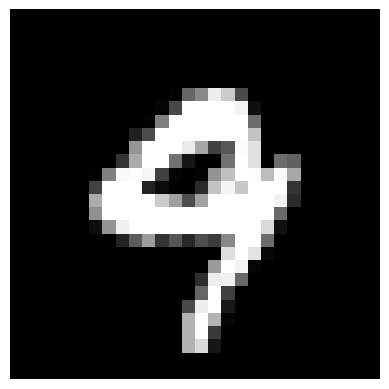

In [39]:
# 随机抽样可视化一下

rand_num = 123
img = x_train[rand_num,:].reshape(28,28)

plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [40]:
# 查看类别名称和类别数量

class_names = np.unique(y_train)
num_classes = class_names.size
print(class_names, num_classes)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 10


# 模型架构搭建

In [41]:
class MyCNN(nn.Cell):
    '''
    模型架构：三个卷积层+全局池化+tanh激活函数，展平连接后接两个全连接层，添加dropout，最后一层softmax输出
    '''
    def __init__(self, input_channels=1, num_classes=10):
        super(MyCNN, self).__init__()
        self.conv_kernel_size = config_para['MNIST']['conv_kernel_size']
        self.pooling_kernel_size = config_para['MNIST']['pooling_kernel_size']
        self.conv_stride = config_para['MNIST']['conv_stride']
        self.pooling_stride = config_para['MNIST']['pooling_stride']
        self.dropout_rate = config_para['MNIST']['dropout_rate']

        # 第一个卷积+池化
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                              out_channels=32,
                              kernel_size=self.conv_kernel_size,
                              stride=self.conv_stride,
                              padding=1,
                              pad_mode='pad',
                              weight_init=Normal(0.02))
        self.pool1 = nn.MaxPool2d(kernel_size=self.pooling_kernel_size,
                                 stride=self.pooling_stride)

        # 第二个卷积+池化
        self.conv2 = nn.Conv2d(in_channels=32,
                              out_channels=64,
                              kernel_size=self.conv_kernel_size,
                              stride=self.conv_stride,
                              padding=1,
                              pad_mode='pad',
                              weight_init=Normal(0.02))
        self.pool2 = nn.MaxPool2d(kernel_size=self.pooling_kernel_size,
                                 stride=self.pooling_stride)

        # 全连接层
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(keep_prob=1 - self.dropout_rate)
        self.fc2 = nn.Dense(128, num_classes)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()

    def construct(self, x):
        x = self.tanh(self.conv1(x))  # (32,28,28)
        x = self.pool1(x)  # (32,14,14)

        x = self.tanh(self.conv2(x))  # (64,14,14)
        x = self.pool2(x)  # (64,7,7)

        x = self.flatten(x)
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# 模型参数配置

In [42]:
# 训练配置

# 模型实例化
network = MyCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.Adam(network.trainable_params(), learning_rate=config_para['train']['lr'])
model = Model(
    network,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metrics={'accuracy'}
)

[WARNING] ME(31168:35156,MainProcess):2024-12-26-14:25:11.632.000 [mindspore\nn\layer\basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


In [43]:
# 自定义Early Stopping函数
class EarlyStop(train.Callback):
    def __init__(self, patience, save_model_path):
        super(EarlyStop, self).__init__()
        self.patience = patience
        self.best_val_acc = -float('inf')
        self.counter = 0
        self.save_model_path = save_model_path
        
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)
    
    def on_eval_end(self, run_context):
        eval_result = run_context.original_args()
        val_acc = eval_result['accuracy']
        
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.counter = 0
            # 保存最佳模型
            ms.save_checkpoint(network, os.path.join(self.save_model_path, 'best_model.ckpt'))
        else:
            self.counter += 1
            if self.counter >= self.patience:
                run_context.request_stop()
                
# 创建Early Stopping实例，设置相关变量
early_stopping = EarlyStop(
    patience=config_para['callback']['patience'],
    save_model_path=config_para['callback']['save_model_path']
)

In [64]:
class MetricsCallback(Callback):
    """用于记录训练过程中的各项指标"""
    def __init__(self, model, val_dataset, config_para):
        super(MetricsCallback, self).__init__()
        self.model = model
        self.val_dataset = val_dataset
        self.config_para = config_para
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        self.best_val_acc = -float('inf')
        self.early_stop_counter = 0
        self.patience = config_para['callback']['patience']
        self.save_model_path = config_para['callback']['save_model_path']
        # 初始化进度条
        self.pbar = tqdm(total=config_para['train']['epochs'], 
                        desc='Training Progress', 
                        position=0, 
                        leave=True)

    def validate(self):
        """执行验证"""
        self.model._network.set_train(False)
        
        val_loss = 0.0
        y_true = []
        y_pred = []
        num_batches = 0
        
        for data in self.val_dataset.create_dict_iterator():
            x_batch = data["image"]
            y_batch = data["label"]
            
            outputs = self.model.predict(x_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += float(loss.asnumpy())
            
            predicted = ops.Argmax()(outputs)
            y_true.extend(y_batch.asnumpy())
            y_pred.extend(predicted.asnumpy())
            num_batches += 1
        
        self.model._network.set_train(True)
        
        return val_loss / num_batches, accuracy_score(y_true, y_pred)

    def on_train_epoch_end(self, run_context):
        """每个训练epoch结束时记录指标"""
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        
        # 记录训练损失
        loss = cb_params.net_outputs
        if isinstance(loss, (tuple, list)):
            loss = loss[0]
        self.train_losses.append(float(loss.asnumpy()))
        
        # 计算验证集指标
        val_loss, val_acc = self.validate()
        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        
        # 修改输出格式以配合tqdm
        self.pbar.set_postfix({
            'Train Loss': f'{self.train_losses[-1]:.4f}',
            'Val Loss': f'{val_loss:.4f}',
            'Val ACC': f'{val_acc:.4f}'
        })
        self.pbar.update(1)
        
        # Early Stopping检查
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.early_stop_counter = 0
            # 保存最佳模型（修改这里）
            ms.save_checkpoint(self.model._network, os.path.join(self.save_model_path, 'best_model.ckpt'))
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.patience:
                print("\nEarly stopping triggered")
                run_context.request_stop()

    def get_metrics(self):
        """获取记录的指标"""
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accs': self.val_accs,
            'best_val_acc': self.best_val_acc
        }
        
    def on_train_end(self, run_context):
        """训练结束时关闭进度条"""
        self.pbar.close()

    def __del__(self):
        """确保在对象被销毁时关闭进度条"""
        if hasattr(self, 'pbar'):
            self.pbar.close()

# 训练

In [65]:
def train_model(model, train_dataset, val_dataset, config_para):
    """训练模型主函数"""
    # 创建指标记录回调
    metrics_callback = MetricsCallback(model, val_dataset, config_para)
    
    # 训练模型
    model.train(config_para['train']['epochs'],
                train_dataset,
                callbacks=[metrics_callback],
                dataset_sink_mode=False)
    
    # 返回训练过程中记录的指标
    return metrics_callback.get_metrics()

In [66]:
metrics = train_model(model, train_loader, val_loader, config_para)

Training Progress:  40%|████      | 12/30 [07:50<11:45, 39.21s/it, Train Loss=1.4612, Val Loss=1.4769, Val ACC=0.9851]


Early stopping triggered


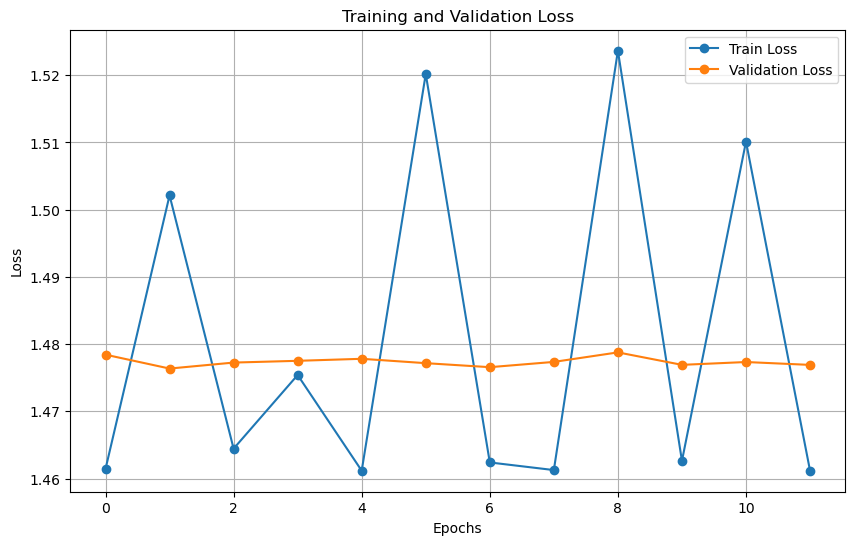

In [67]:
# 绘制训练和验证损失曲线
def plot_loss(train_losses, val_losses):
    """
    Simple version of loss plotting, similar to the original implementation
    
    Args:
        train_losses (list): List of training losses
        val_losses (list): List of validation losses
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
plot_loss(metrics['train_losses'], metrics['val_losses'])

# 训练评估与测试

In [71]:
# 测试函数
def test(model, dataset):
    model._network.set_train(False)
    
    correct = 0
    total = 0
    
    for data in dataset.create_dict_iterator():
        x_batch = data["image"]
        y_batch = data["label"]
        
        outputs = model.predict(x_batch)
        predicted = ops.Argmax()(outputs)
        
        total += y_batch.shape[0]
        correct += (predicted == y_batch).sum().asnumpy().item()
        
    # 回到训练模式
    model._network.set_train(True)
    
    accuracy = correct / total
    return accuracy

In [72]:
# 加载最佳模型参数（这里是把torch.load_state_dict()分开了！）
param_dict = load_checkpoint(os.path.join(early_stopping.save_model_path, 'best_model.ckpt'))
load_param_into_net(model._network, param_dict)

test_accuracy = test(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9842
